In [ ]:
import torch
import numpy as np, cv2, pandas as pd, glob, time, os
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets

import importlib, GenderAgeEstimation as gae
importlib.reload(gae)


<module 'GenderAgeEstimation' from '/home/onkar/projects/GenderAgeEstimation/GenderAgeEstimation.py'>

In [ ]:
ff_train_df = pd.read_csv('../data/fairface/fairface_label_train.csv')
ff_valid_df = pd.read_csv('../data/fairface/fairface_label_val.csv')
print(f'Training dataset size : {len(ff_train_df)},\nValidation dataset size: {len(ff_valid_df)}')

Training dataset size : 86744,
Validation dataset size: 10954


In [ ]:
ff_train_df.head(10)

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True
5,train/6.jpg,20-29,Male,White,True
6,train/7.jpg,40-49,Male,Middle Eastern,False
7,train/8.jpg,30-39,Female,Indian,True
8,train/9.jpg,10-19,Male,White,True
9,train/10.jpg,30-39,Male,Middle Eastern,False


In [ ]:
ff_valid_df.head(10)

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False
5,val/6.jpg,30-39,Male,Latino_Hispanic,False
6,val/7.jpg,20-29,Male,Black,True
7,val/8.jpg,3-9,Male,East Asian,False
8,val/9.jpg,20-29,Male,Southeast Asian,False
9,val/10.jpg,3-9,Male,Southeast Asian,False


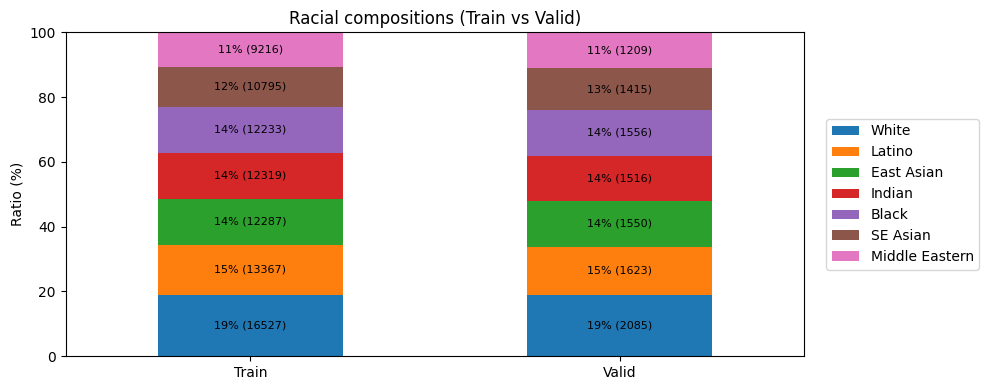

(race       White     Latino  East Asian     Indian      Black   SE Asian  \
 Train  19.052615  15.409711   14.164668  14.201559  14.102416  12.444665   
 Valid  19.034143  14.816505   14.150082  13.839693  14.204857  12.917656   
 
 race   Middle Eastern  
 Train       10.624366  
 Valid       11.037064  ,
 race   White  Latino  East Asian  Indian  Black  SE Asian  Middle Eastern
 Train  16527   13367       12287   12319  12233     10795            9216
 Valid   2085    1623        1550    1516   1556      1415            1209)

In [ ]:
rename_map = {
    "Latino_Hispanic": "Latino",
    "Southeast Asian": "SE Asian",
}

gae.plot_race_composition_with_labels(
    {"Train": ff_train_df, "Valid": ff_valid_df},
    race_col="race",
    rename_map=rename_map,
    title="Racial compositions (Train vs Valid)",
    min_pct_to_label=3.0
)

### **Data Partitioning Strategy: Ensuring Unbiased Generalization**

While the original source data is organized into traditional training and validation sets, I prefer a more rigorous **three-way split (Train, Validation, and Test)** to ensure the integrity of the model’s performance metrics. To achieve this, I implemented a custom data pipeline to re-partition the combined pool of images.

#### **1. Rationale for the Three-Way Split**

In many public benchmarks—including **FairFace**, **CelebA**, and **UTKFace** datasets ship with predefined splits that may not include a dedicated held-out test set for your specific pipeline. However, to build a deployment-ready system, a dedicated **Test Set** is essential to serve as a true "holdout" that remains untouched during the development phase:

* **Training Set:** Used to optimize the model’s weights and teach it to recognize facial attributes.
* **Validation Set:** Used exclusively for hyperparameter tuning and model selection, preventing the architecture from "overfitting" to a specific configuration.
* **Test Set:** An independent "black-box" set used only once—after all training and tuning is complete—to measure how the system generalizes to unseen global populations.

#### **2. Methodology: The Re-Splitting Process**

To maintain statistical rigor, I followed a structured re-partitioning workflow:

* **Data Consolidation:** I combined the existing training and validation subsets into a single unified pool to regain the full diversity of the original dataset.
* **Stratified Re-Splitting:** I applied a stratified sampling technique to re-split the consolidated data into three new silos. This ensures that the **demographic balance**—the 7 race groups, 2 genders, and 9 age bins—is preserved identically across the Train, Val, and Test sets.
* **Splits are identity-disjoint:** (no subject appears in more than one split) to prevent identity leakage.
* **Independence Verification:** This process guarantees that the final performance reports are completely unbiased, as the model is evaluated on images that never influenced the training gradients or the hyperparameter selection process.

In [ ]:
# ...existing code...
from contextlib import nullcontext

def train_one_epoch_fairface(
    model, optimizer, train_dl, *, label_smoothing: float = 0.0,
    device: torch.device = torch.device("cuda"), scaler=None, amp: bool = True
):
    model.train()

    use_amp = amp and (device.type == "cuda")
    autocast_ctx = torch.cuda.amp.autocast if use_amp else nullcontext

    total = 0
    running_loss = {"age": 0.0, "gender": 0.0, "race": 0.0, "total": 0.0}
    running_acc  = {"age": 0.0, "gender": 0.0, "race": 0.0, "mean": 0.0}

    for batch in train_dl:
        optimizer.zero_grad(set_to_none=True)
        imgs, targets, _ = _unpack_batch(batch, device)

        with autocast_ctx():
            preds = model(imgs)
            total_loss, loss_parts = multitask_loss(preds, targets, label_smoothing=label_smoothing)

        if use_amp and scaler is not None:
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            total_loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total += bs

        with torch.inference_mode():
            accs = multitask_accuracies(preds, targets)

        running_loss["total"] += float(total_loss.detach().item()) * bs
        running_loss["age"]   += float(loss_parts["age"].item()) * bs
        running_loss["gender"]+= float(loss_parts["gender"].item()) * bs
        running_loss["race"]  += float(loss_parts["race"].item()) * bs

        running_acc["age"]    += float(accs["age"].item()) * bs
        running_acc["gender"] += float(accs["gender"].item()) * bs
        running_acc["race"]   += float(accs["race"].item()) * bs
        running_acc["mean"]   += float(accs["mean"].item()) * bs

    return {k: v / total for k, v in running_loss.items()}, {k: v / total for k, v in running_acc.items()}


@torch.inference_mode()
def eval_one_epoch_fairface(
    model, eval_dl, *, label_smoothing: float = 0.0,
    device: torch.device = torch.device("cuda"), amp: bool = True
):
    model.eval()

    use_amp = amp and (device.type == "cuda")
    autocast_ctx = torch.cuda.amp.autocast if use_amp else nullcontext

    total = 0
    running_loss = {"age": 0.0, "gender": 0.0, "race": 0.0, "total": 0.0}
    running_acc  = {"age": 0.0, "gender": 0.0, "race": 0.0, "mean": 0.0}

    for batch in eval_dl:
        imgs, targets, _ = _unpack_batch(batch, device)

        with autocast_ctx():
            preds = model(imgs)
            total_loss, loss_parts = multitask_loss(preds, targets, label_smoothing=label_smoothing)
            accs = multitask_accuracies(preds, targets)

        bs = imgs.size(0)
        total += bs

        running_loss["total"] += float(total_loss.item()) * bs
        running_loss["age"]   += float(loss_parts["age"].item()) * bs
        running_loss["gender"]+= float(loss_parts["gender"].item()) * bs
        running_loss["race"]  += float(loss_parts["race"].item()) * bs

        running_acc["age"]    += float(accs["age"].item()) * bs
        running_acc["gender"] += float(accs["gender"].item()) * bs
        running_acc["race"]   += float(accs["race"].item()) * bs
        running_acc["mean"]   += float(accs["mean"].item()) * bs

    return {k: v / total for k, v in running_loss.items()}, {k: v / total for k, v in running_acc.items()}
# ...existing code...

**Data Consolidation:**

In [ ]:
ff_train_df.head(10)

root = "/home/onkar/projects/data/fairface"
out = gae.CSVMerger(root).build_full("fairface_label_train.csv", "fairface_label_val.csv", "fairface_label_full.csv")

ff_full_df = pd.read_csv(out)

print(ff_full_df.shape)
ff_full_df.head(10)

(97698, 6)


,file,age,gender,race,service_test,split
0,train/65360.jpg,10-19,Male,Black,False,train
1,train/43448.jpg,3-9,Female,White,True,train
2,train/61505.jpg,3-9,Female,Black,False,train
3,train/12424.jpg,30-39,Female,Black,False,train
4,train/79886.jpg,20-29,Male,Indian,True,train
5,train/64105.jpg,40-49,Female,White,False,train
6,train/33622.jpg,30-39,Male,Middle Eastern,False,train
7,train/32999.jpg,30-39,Male,White,True,train
8,val/10790.jpg,30-39,Female,Southeast Asian,False,val
9,train/8664.jpg,50-59,Male,East Asian,False,train


 **Stratified Re-Splitting:**

In [ ]:
def count_unique_age_bins(df, age_col="age"):
    bins = (
        df[age_col]
        .astype("string")
        .str.strip()
        .dropna()
    )
    n_unique = bins.nunique()
    uniq = bins.unique().tolist()
    return n_unique, sorted(uniq)

# ---------- USAGE ----------
n_bins, age_bins = count_unique_age_bins(ff_full_df, age_col="age")
print("Unique age bins:", n_bins)
print("Bins:", age_bins)


Unique age bins: 9
Bins: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']


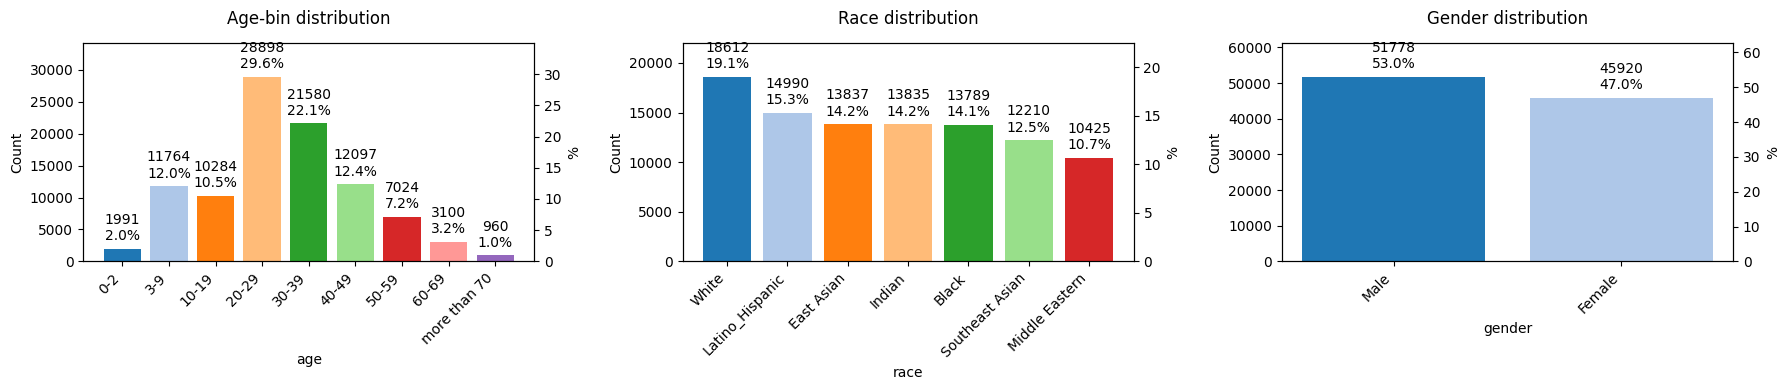

In [ ]:
fig, axes = gae.plot_agebin_race_gender_distributions(ff_full_df, normalize=True)
plt.show()

In [ ]:
splitter = gae.FairFaceSplitter(seed=42)

train_df, val_df, test_df = splitter.split(
    ff_full_df,
    test_size=0.10,   # 10% test
    val_size=0.15,    # 10% val
    out_dir="/home/onkar/projects/data/fairface/splits",
    prefix="ff_",
)

print("train/val/test:", len(train_df), len(val_df), len(test_df))
print("split counts:\n", pd.concat([train_df, val_df, test_df])["split"].value_counts())


train/val/test: 73273 14655 9770
split counts:
 split
train    73273
val      14655
test      9770
Name: count, dtype: int64


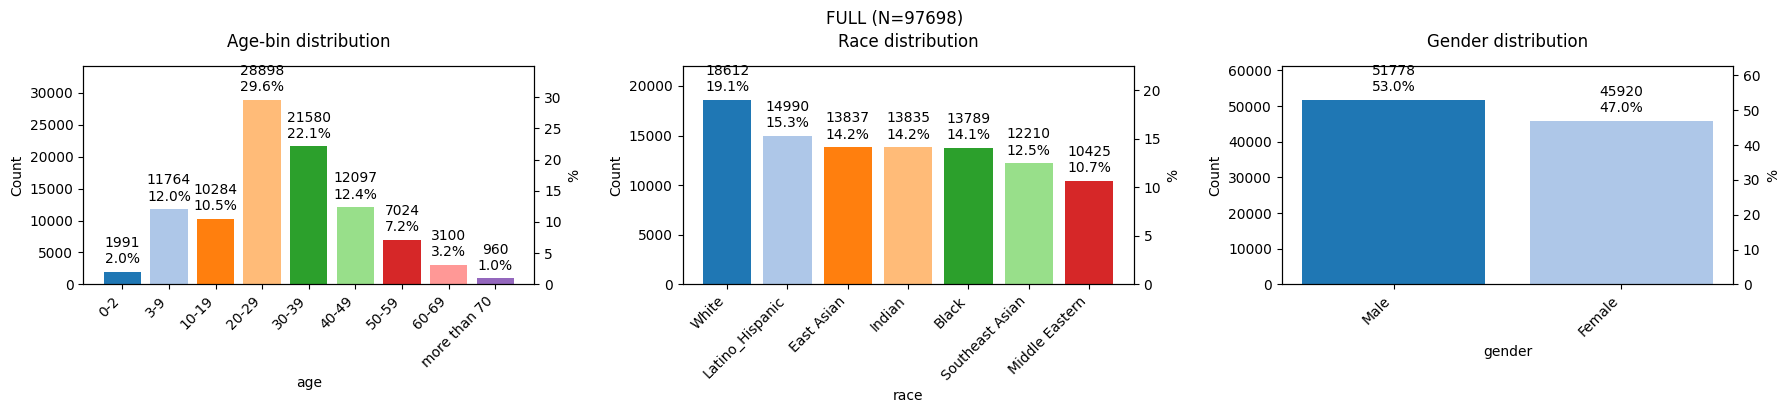

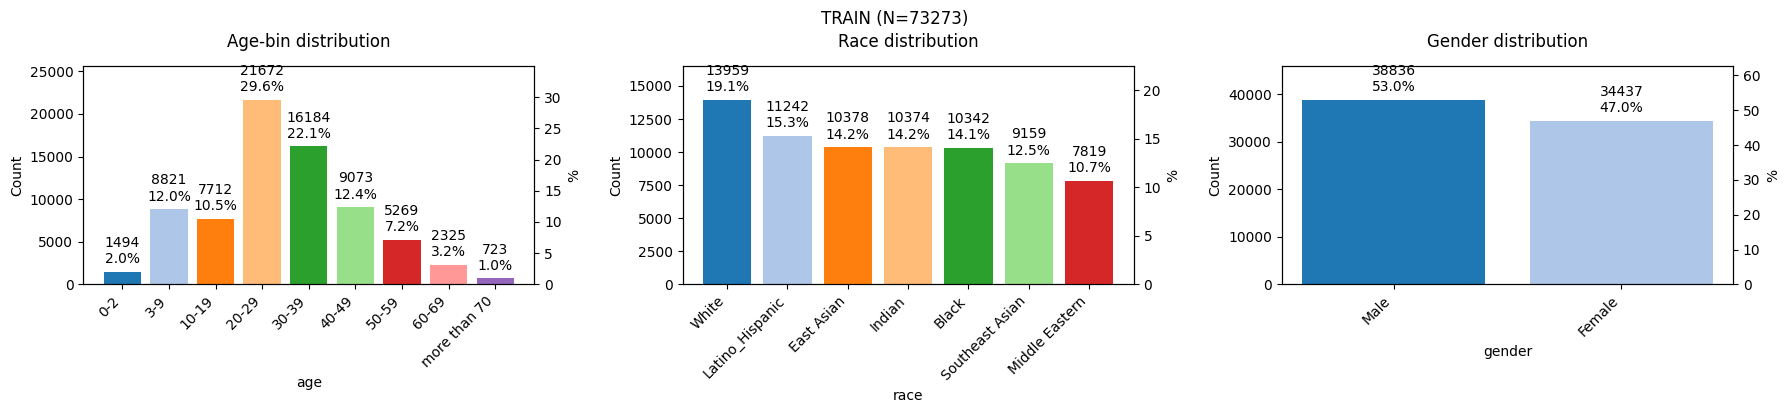

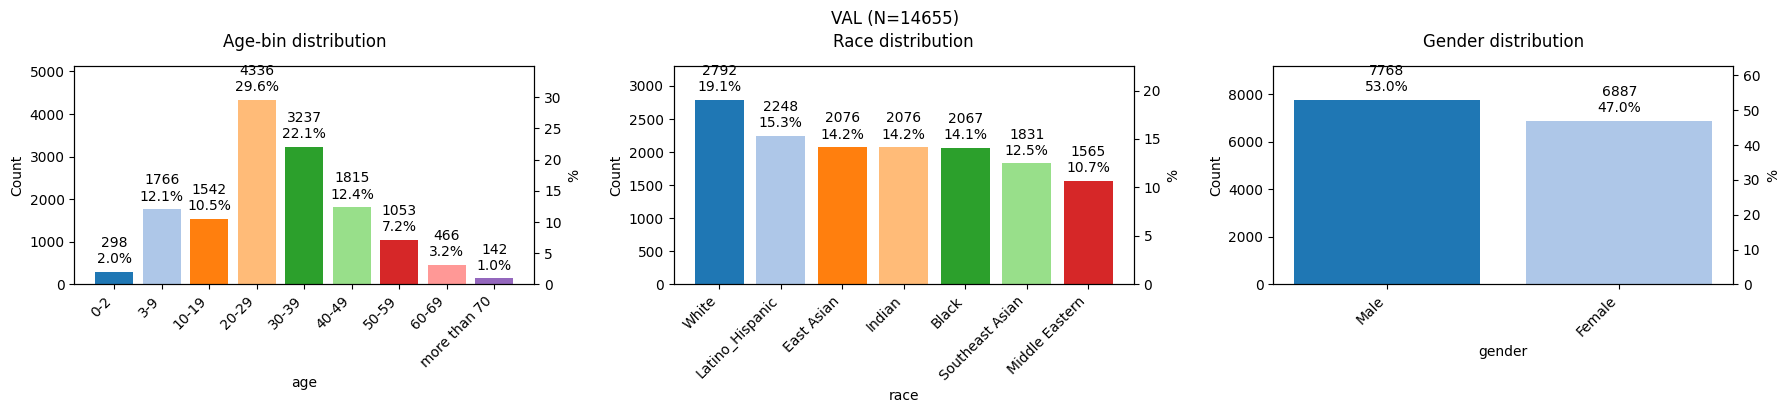

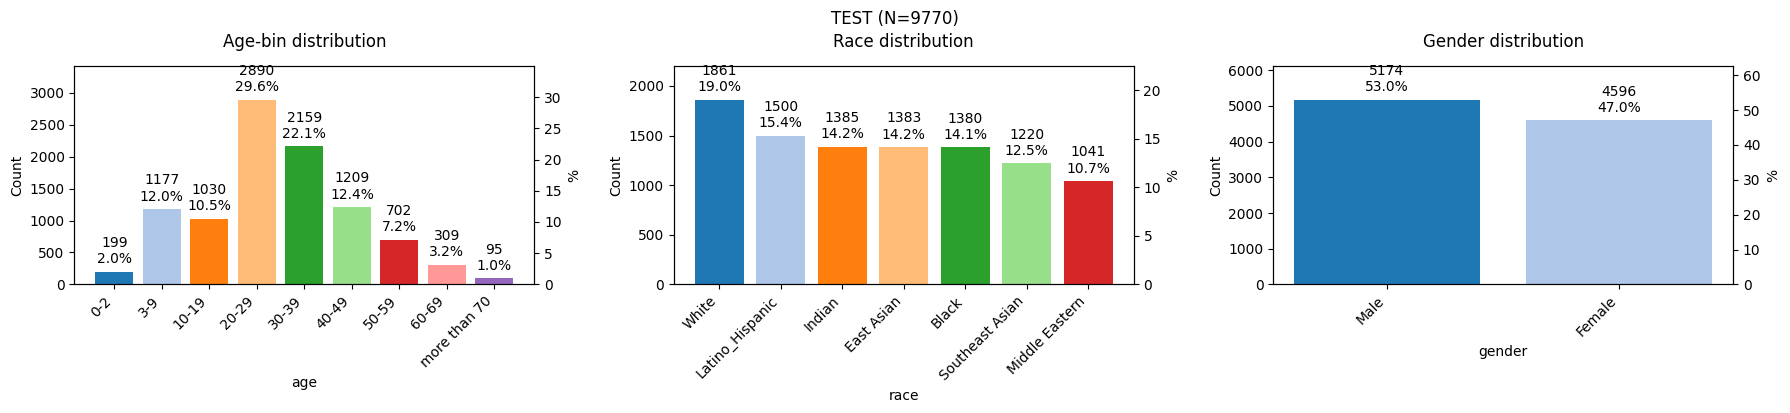

In [ ]:
dfs = {
    "FULL": ff_full_df,
    "TRAIN": train_df,
    "VAL": val_df,
    "TEST": test_df,
}

for name, df in dfs.items():
    fig, axes = gae.plot_agebin_race_gender_distributions(df, normalize=True)

    # add a suptitle so you know which split this is
    fig.suptitle(f"{name} (N={len(df)})", y=1.02)

    plt.show()
    plt.close(fig)  # avoid accumulating figures in notebooks


In [ ]:
full_split_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

splits_per_file = full_split_df.groupby("file")["split"]
per_file_splits = splits_per_file.unique()

per_file_splits.head(10)


file
train/1.jpg        [train]
train/10.jpg       [train]
train/100.jpg      [train]
train/1000.jpg     [train]
train/10000.jpg    [train]
train/10001.jpg    [train]
train/10002.jpg      [val]
train/10003.jpg    [train]
train/10004.jpg    [train]
train/10005.jpg    [train]
Name: split, dtype: object

**Splits are identity-disjoint:**

In [ ]:
checker = gae.SplitLeakageChecker()
full_split_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
checker.assert_no_duplicate_files(full_split_df, file_col="file")

checker.assert_file_disjoint(full_split_df, file_col="file", split_col="split")

print("File-disjoint verified (no image appears in multiple splits).")

File-disjoint verified (no image appears in multiple splits).
